In [4]:
import matplotlib.pyplot as plt

import librosa
from librosa.feature import melspectrogram
from librosa.core import load
from librosa.display import specshow
from librosa import power_to_db

import numpy as np
import pandas as pd
import random
import os
import pickle

from tqdm import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim    
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from transformers import AutoFeatureExtractor
from transformers import ASTForAudioClassification

import collections

g:\python3.9.5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
feature_extractor = AutoFeatureExtractor.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")

In [42]:
# def make_noises():
#     normal_noise = np.random.normal(mean, 0.001, size=num_samples)

class FeatureExtractor():
    def __init__(self, extractor):
        self.extractor = extractor
        self.cashed_audio = collections.deque(maxlen=10)
        
    def add_white_noise(self, wav):
        noise_power = (sum(wav ** 2) ** 0.5) / (5 * len(wav))
        noise = np.random.normal(0, noise_power, size=len(wav))
        return wav + noise
    
    def add_random_sounds(self, wav, cnt):
        rnd = np.random.default_rng()
        noises = rnd.integers(low=0, high=len(self.cashed_audio) - 1, size=cnt)
        alpha = 0.98
        return alpha * wav + (1 - alpha) * sum(noises) / len(noises)
    
    def make_feature(self, wav, sr):
        res = []
        
        noised_wav = self.add_white_noise(wav)
        res.append(self.extractor(noised_wav, sampling_rate=sr)['input_values'])
        
        if len(self.cashed_audio) > 1:
            noised_wav = self.add_random_sounds(wav, 1)
            res.append(self.extractor(noised_wav, sampling_rate=sr)['input_values'])
        
        if len(self.cashed_audio) > 2:
            noised_wav = self.add_random_sounds(wav, 2)
            res.append(self.extractor(noised_wav, sampling_rate=sr)['input_values'])
        
        self.cashed_audio.append(wav)
        
        return res

def make_features(path, sr, extractor):
    wav_data, sr = load(path, sr=sr)
    
    if len(wav_data) == 0:
        wav_data = np.zeros(sr)
    
    return extractor.make_feature(wav_data, sr)

def store_train_features(file_label:dict, path_to_files, out_path, sr, extractor):
    feats = []
    
    print('Total files:', len(file_label))
    
    specific_extractor = FeatureExtractor(extractor)
    
    for i, (file_name, label) in tqdm(enumerate(file_label.items())):
        features = make_features(os.path.join(path_to_files, file_name), sr, specific_extractor)
        
        for f in features:
            feats.append({
                'fname': file_name,
                'feature': f,
                'label_id': label
            })
        
    pickle.dump(feats, open(out_path, 'wb'))
    
def read_labels_info(path_to_csv):
    meta = pd.read_csv(path_to_csv, skiprows=1, names=['fname', 'label', 'manually_verified'])
    label_to_id = {label: i for i, label in enumerate(set(meta['label']))}
    meta['label_id'] = [label_to_id[label] for label in meta['label']]
    
    return meta
    
def make_file_label_dict(labels_info):
    return dict(zip(labels_info['fname'].values, labels_info['label_id'].values))

In [43]:
train_folder = '../../data/train/'
# test_folder = './data/audio_test/'

sample_rate = 16000

In [44]:
path_to_csv = os.path.join('../../data/', 'train.csv')

labels_info = read_labels_info(path_to_csv)

pickle_train_path = os.path.join('train.pickle')

store_train_features(make_file_label_dict(labels_info), train_folder, pickle_train_path, sample_rate, feature_extractor)

Total files: 5683


5683it [04:03, 23.32it/s]


In [45]:
wav_data, sr = load(train_folder + '00abfb8903f34a38d7c3.wav', sr=sample_rate)
res = feature_extractor(wav_data, sampling_rate=sr, return_tensors="pt")

print(len(res))
print(res['input_values'].shape)

1
torch.Size([1, 1024, 128])


In [46]:
import pickle
import os
from sklearn.model_selection import train_test_split

pickle_train_path = os.path.join('train.pickle')
pickle_train_data = pd.DataFrame(pickle.load(open(pickle_train_path, 'rb')))

x_tr, x_val, y_tr, y_val = train_test_split(pickle_train_data['feature'].values, 
                                            pickle_train_data['label_id'].values, 
                                            test_size=0.25)

[[[-1.2128524  -1.2775939  -1.158659   ... -0.6408719  -0.49223962
   -0.579536  ]
  [-1.191726   -1.2775939  -1.1622274  ... -0.6212456  -0.6720337
   -0.54846805]
  [-1.2061108  -1.2775939  -1.2562853  ... -0.5399623  -0.5562741
   -0.48124805]
  ...
  [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
    0.46703237]
  [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
    0.46703237]
  [ 0.46703237  0.46703237  0.46703237 ...  0.46703237  0.46703237
    0.46703237]]]


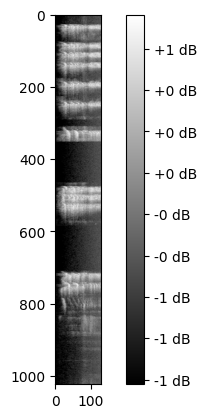

In [51]:
def print_features(features, title=None):
    plt.imshow(features, cmap='gray')
    
    plt.colorbar(format="%+2.f dB")
    plt.show()
    
print(np.asarray(x_tr[0]))
print_features(np.asarray(x_tr[5][0]))

In [52]:
model = ASTForAudioClassification.from_pretrained("MIT/ast-finetuned-audioset-10-10-0.4593")
# inputs = feature_extractor(, sampling_rate=sample_rate, return_tensors="pt")

with torch.no_grad():
    logits = model(torch.from_numpy(np.asarray(x_tr[0]))).logits

predicted_class_ids = torch.argmax(logits, dim=-1).item()
predicted_label = model.config.id2label[predicted_class_ids]
predicted_label

'Knock'

In [53]:
model

ASTForAudioClassification(
  (audio_spectrogram_transformer): ASTModel(
    (embeddings): ASTEmbeddings(
      (patch_embeddings): ASTPatchEmbeddings(
        (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ASTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ASTLayer(
          (attention): ASTAttention(
            (attention): ASTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ASTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ASTIntermediate(
            (de

In [54]:
class ResNet(nn.Module):
    def __init__(self, pretrained):
        super(ResNet, self).__init__()

        self.main = pretrained

        self.main.classifier.dense = nn.Linear(768, 41)

    def forward(self, x):
        x = self.main(x)

        return F.sigmoid(x.logits)

In [55]:
ResNet(model)

ResNet(
  (main): ASTForAudioClassification(
    (audio_spectrogram_transformer): ASTModel(
      (embeddings): ASTEmbeddings(
        (patch_embeddings): ASTPatchEmbeddings(
          (projection): Conv2d(1, 768, kernel_size=(16, 16), stride=(10, 10))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ASTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ASTLayer(
            (attention): ASTAttention(
              (attention): ASTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ASTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
          

In [13]:
class EventDetectionDataset(Dataset):
    def __init__(self, x, y=None):
        self.x = x
        self.y = y
    
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        current = torch.Tensor(self.x[idx][0])
        if self.y is not None:
            return current, self.y[idx]
        return current

In [14]:
train_dset = EventDetectionDataset(x_tr[:1000], y_tr[:1000])
train_loader = DataLoader(train_dset, batch_size=1, shuffle=True, num_workers=0)

val_dset = EventDetectionDataset(x_val, y_val)
val_loader = DataLoader(val_dset, batch_size=1, shuffle=False, num_workers=0)

In [15]:
def init_random_state(random_state:int=0):
    random.seed(random_state)
    np.random.seed(random_state)
    torch.manual_seed(random_state)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(random_state)
        torch.cuda.manual_seed_all(random_state)
        
random_state = 11

os.environ["PYTHONHASHSEED"] = str(random_state)
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"

torch.use_deterministic_algorithms(False)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

init_random_state(random_state)

In [16]:
for feture, label in train_loader:
    network = ResNet(model)
    print(feture.shape)
    network.to("cpu")
    output = network(feture)
    break

torch.Size([1, 1024, 128])


In [17]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

n_epoch = 10
criterion = nn.CrossEntropyLoss()
network = ResNet(model)
network.to(device)
optimizer = optim.AdamW(network.parameters(), lr=0.000001)

train_loss = []
val_loss = []

train_acc = []
val_acc = []

for e in range(n_epoch):
    print('epoch #', e)
    # train
    loss_list = []
    outputs = []
    targets = []
    for i_batch, sample_batched in tqdm(enumerate(train_loader)):
        x, y = sample_batched
        optimizer.zero_grad()

        output = network(x.to(device))
        outputs.append(output.argmax(axis=1))
    
        target = y.to(device)
        targets.append(target)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
        loss = criterion(output, target.long())
        loss_list.append(loss.item())
        loss.backward()
        optimizer.step()
    y_true = torch.hstack(targets).numpy(force=True)
    y_pred = torch.hstack(outputs).numpy(force=True)
    acc = accuracy_score(y_true, y_pred)
    train_loss.append(np.mean(loss_list))
    train_acc.append(acc)
    print('mean train loss:', train_loss[-1])
    print('train accuracy:', acc)
    
    
    loss_list = []
    outputs = []
    targets = []
    with torch.no_grad():
        for i_batch, sample_batched in enumerate(val_loader):
            x, y = sample_batched
#             optimizer.zero_grad()

            output = network(x.to(device))
            outputs.append(output.argmax(axis=1))

            target = y.to(device)
            targets.append(target)

            loss = criterion(output, target.long())
            loss_list.append(loss.item())
#             loss.backwrd()
#             optimizer.step()
            
        y_true = torch.hstack(targets).numpy(force=True)
        y_pred = torch.hstack(outputs).numpy(force=True)
        acc = accuracy_score(y_true, y_pred)
        val_loss.append(np.mean(loss_list))
        val_acc.append(acc)
        print('mean val loss:', val_loss[-1])
        print('val accuracy:', acc)                                                                                                                                                                                                                                                                                                                                                                                             

epoch # 0


1000it [05:31,  3.01it/s]


mean train loss: 3.590038162946701
train accuracy: 0.164
mean val loss: 3.4753181027907267
val accuracy: 0.362121567707111
epoch # 1


1000it [05:30,  3.02it/s]


mean train loss: 3.358804944038391
train accuracy: 0.565
mean val loss: 3.327891613054488
val accuracy: 0.5907064069467262
epoch # 2


1000it [05:57,  2.80it/s]


mean train loss: 3.2194290490150452
train accuracy: 0.774
mean val loss: 3.235935679178119
val accuracy: 0.681764843933349
epoch # 3


1000it [05:40,  2.94it/s]


mean train loss: 3.1281958644390104
train accuracy: 0.859
mean val loss: 3.1749300735709087
val accuracy: 0.722365641868106
epoch # 4


1000it [05:35,  2.98it/s]


mean train loss: 3.0648808598518373
train accuracy: 0.908
mean val loss: 3.1346883035215294
val accuracy: 0.7444261910349683
epoch # 5


1000it [05:39,  2.95it/s]


mean train loss: 3.017331233739853
train accuracy: 0.935
mean val loss: 3.1073279455776257
val accuracy: 0.7608542595634827
epoch # 6


1000it [05:42,  2.92it/s]


mean train loss: 2.9803352839946746
train accuracy: 0.96
mean val loss: 3.0843102558765354
val accuracy: 0.7786904482515842
epoch # 7


1000it [05:42,  2.92it/s]


mean train loss: 2.9504645252227784
train accuracy: 0.975
mean val loss: 3.0661739589070747
val accuracy: 0.7775170147852617
epoch # 8


1000it [05:40,  2.94it/s]


mean train loss: 2.925187318563461
train accuracy: 0.979
mean val loss: 3.049293174678746
val accuracy: 0.7906594696080732
epoch # 9


1000it [05:40,  2.94it/s]


mean train loss: 2.9032511858940127
train accuracy: 0.985
mean val loss: 3.035915167055844
val accuracy: 0.797700070406008


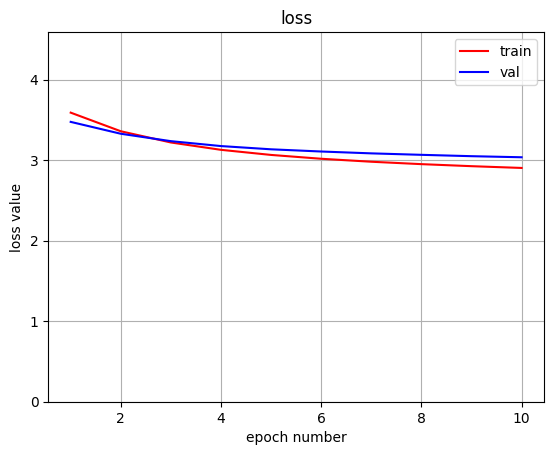

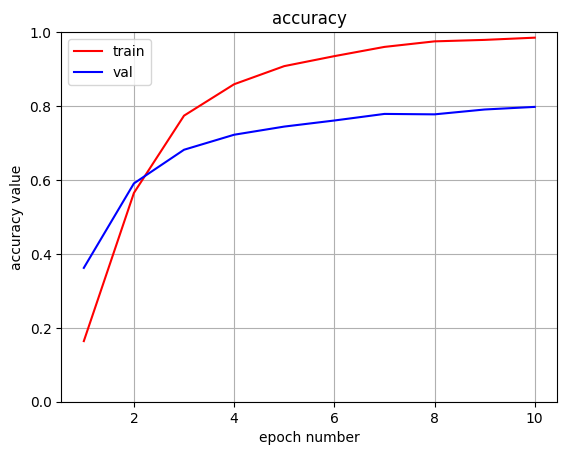

In [18]:
epochs = np.arange(1, n_epoch+1)

axes = plt.gca()
axes.set_ylim([0,max(max(train_loss), max(val_loss))+1])
plt.plot(epochs, train_loss, 'r', label='train')
plt.plot(epochs, val_loss, 'b', label='val')
plt.title('loss')
plt.xlabel('epoch number')
plt.ylabel('loss value')
plt.legend()
plt.grid()
plt.show()


axes = plt.gca()
axes.set_ylim([0,1])
plt.plot(epochs, train_acc, 'r', label='train')
plt.plot(epochs, val_acc, 'b', label='val')
plt.title('accuracy')
plt.xlabel('epoch number')
plt.ylabel('accuracy value')
plt.legend()
plt.grid()
plt.show()